# Practica 2 - Grupo 05

* **Boris Carballa Corredoira**
* **Juan Carlos Villanueva Quirós**
* **Francisco Javier Blázquez Martínez**

## Parte 1. Análisis de sentimiento

### Apartado a)

En primer lugar, vamos a importar todas las librerías necesarias para ejecutar de manera correcta el Notebook. Fijamos también la variable random_state para que los resultados del Notebook sean reproducibles en todo momento. Por defecto, esta tendrá el valor 11520.

Posteriormente, definimos una serie de funciones auxiliares que vamos a usar durante este primer apartado. Comentamos aquí brevemente cada una de dichas funciones. En caso de que se quieran conocer más a fondo, recomendamos consultar el código, pues este está documentado y comentado.

Las funciones que vamos a usar en este primer apartado son:

+ **select_vectorizer**: selecciona una representación de bolsa de palabras, devolviendo el vectorizer adecuado y crea la matriz de  datos para los conjuntos de entrenamiento y de test.
    
+ **naive_bayes_multinomial**: dados la matriz de datos de entrenamiento y test y el conjunto de targets de entrenamiento y test, crea un Naive Bayes Multinomial, lo entrena y lo evalúa. Los resultados pueden ser mostrados por pantalla.
    
+ **naive_bayes_gaussian**: dados la matriz de datos de entrenamiento y test y el conjunto de targets de entrenamiento y test, crea un Naive Bayes Gaussiano, lo entrena y lo evalúa. Los resultados pueden ser mostrados por pantalla.
    
+ **decission_tree_optimum**: dados la matriz de datos de entrenamiento y test y el conjunto de targets de entrenamiento y test, elige la profundidad óptima, crea el árbol a dicha profundidad, lo entrena y lo evalúa. Los resultados pueden ser mostrados por pantalla.
    
+ **highlight_min_max**: función auxiliar para dar formato a la tabla de resultados final. Simplemente aumenta la visualizacion de los resultados.
    
+ **print_top25_features_per_class_in_NB**: imprime las 25 variables de un Naive Bayes con más presencia en cada clase.     

+ **print_top25_features_in_trees**: imprime las 25 variables de un árbol con más poder discrimante.  
    

In [1]:
# Importamos todas las librerías necesarias aquí
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection         import train_test_split
from sklearn.naive_bayes             import MultinomialNB
from sklearn.naive_bayes             import GaussianNB
from sklearn.model_selection         import cross_validate
from sklearn                         import tree
from sklearn.tree                    import plot_tree
from sklearn.metrics                 import confusion_matrix
from sklearn.metrics                 import classification_report
from sklearn.utils.multiclass        import unique_labels

import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

random_option = 11520

In [3]:
def select_vectorizer(categoria, ngrama, train_X, test_X):
    """
    Selecciona una representación de bolsa de palabras, devolviendo el 
    vectorizer adecuado y crea la matriz de datos para los datos
    de entrenamiento y de test.
    
    Dada la categoría deseada (Binario o TF-IDF) y el rango de N-Grama a usar
    crea y devuelve el vectorizer, train_vector_data y test_vector_data adecuados.
    
    Parametros:
    categoria -- "Binario" o "TF-IDF"
    ngrama -- tupla con el rango del N-Grama
    train_X -- matriz con los datos de entrenamiento sin procesar
    test_X -- matriz con los datos de test sin procesar
    
    """
    
    bin_option = categoria == 'Binario'

    # Creamos el vectorizer
    vectorizer = CountVectorizer(stop_words = 'english', binary = bin_option, ngram_range = ngrama)
    
    train_vector_data = vectorizer.fit_transform(train_X['sentence'])
    test_vector_data = vectorizer.transform(test_X['sentence'])
    
    if(not(bin_option)) :
        tfidfer = TfidfTransformer()
        train_preprocessed = tfidfer.fit_transform(train_vector_data)
        test_preprocessed = tfidfer.transform(test_vector_data)
        return (vectorizer, train_preprocessed, test_preprocessed) 
    else :
        return (vectorizer, train_vector_data, test_vector_data)

In [4]:
def naive_bayes_multinomial(train_data, train_target, test_data, test_target, show = True):
    """
    Ejecuta un Naive Bayes Multinomial
    
    Dados la matriz de datos de entrenamiento y test y el conjunto de targets de
    entrenamiento y test, crea un Naive Bayes Multinomial, lo entrena y lo evalúa.
    Los resultados pueden ser mostrados por pantalla.
    
    Parámetros:
    train_data -- matriz de datos de entrenamiento
    train_target -- target de entrenamiento
    test_data -- matriz de datos de test
    test_target -- target de test
    show -- booleano para mostrar o no los resultados por pantalla
    
    """
    
    # Creamos el Naive Bayes Multinommial
    mnb_classifier = MultinomialNB()
    
    # Lo entrenamos con los datos de entrenamiento
    mnb_classifier.fit(train_data, train_target)

    # Lo evaluamos, calculando las predicciones con los datos de test y entrenamiento
    mnb_train_predictions = mnb_classifier.predict(train_data)
    mnb_test_predictions = mnb_classifier.predict(test_data)

    # Calculamos la accuracy para el entrenamiento y el test
    ac_train = np.mean(mnb_train_predictions == train_target)
    ac_test = np.mean(mnb_test_predictions == test_target)

    # Si show = True, mostramos los resultados por pantalla
    if(show) :
        print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: ", ac_train)
        print("Multinomial Naive Bayes, porcentaje de aciertos en test: ", ac_test)
    
    return (ac_train, ac_test), mnb_classifier

In [5]:
def naive_bayes_gaussian(train_data, train_target, test_data, test_target, show = True):
    """
    Ejecuta un Naive Bayes Gaussiano
    
    Dados la matriz de datos de entrenamiento y test y el conjunto de targets de
    entrenamiento y test, crea un Naive Bayes Gaussiano, lo entrena y lo evalúa.
    Los resultados pueden ser mostrados por pantalla.
    
    Parámetros:
    train_data -- matriz de datos de entrenamiento
    train_target -- target de entrenamiento
    test_data -- matriz de datos de test
    test_target -- target de test
    show -- booleano para mostrar o no los resultados por pantalla
    
    """
    
    # Creamos el Naive Bayes Gaussiano
    gnb_classifier = GaussianNB()

    # Lo entrenamos y evaluamos por partes para evitar problemas con matrices dispersas
    chunk_size = 100
    num_rows = len(train_target)

    for i in range(0, (num_rows//chunk_size)):
        train_chunk = train_data[i*chunk_size : (i+1)*chunk_size,:].toarray()
        target_chunk = train_target[i*chunk_size : (i+1)*chunk_size]
        gnb_classifier.partial_fit(train_chunk, target_chunk, classes=np.unique(train_target))

    # Creamos los arrays antes para ser más eficiente (crea el array grande y luego lo rellena)
    gnb_train_predictions = np.zeros_like(train_target)
    gnb_test_predictions = np.zeros_like(test_target)

    for i in range(0, (num_rows//chunk_size)):
        train_chunk = train_data[i*chunk_size : (i+1)*chunk_size,:].toarray()
        gnb_train_predictions[i*chunk_size : (i+1)*chunk_size] = gnb_classifier.predict(train_chunk)

    num_rows = len(test_target)
    for i in range(0, (num_rows//chunk_size)):
        test_chunk = test_data[i*chunk_size : (i+1)*chunk_size,:].toarray()
        gnb_test_predictions[i*chunk_size : (i+1)*chunk_size] = gnb_classifier.predict(test_chunk)
 
    # Calculamos la accuracy para el entrenamiento y el test
    ac_train = np.mean(gnb_train_predictions == train_target)
    ac_test = np.mean(gnb_test_predictions == test_target)
    
    # Si show = True, mostramos los resultados por pantalla
    if (show) :
        print("Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento: ", ac_train)
        print("Gaussian Naive Bayes, porcentaje de aciertos en test: ", ac_test)
    
    return (ac_train, ac_test), gnb_classifier  

In [6]:
def decission_tree_optimum(train_data, train_target, test_data, test_target, show = True):
    """
    Ejecuta un Árbol de Decisión a la profundidad óptima.
    
    Dados la matriz de datos de entrenamiento y test y el conjunto de targets de
    entrenamiento y test, elige la profundidad óptima, crea el árbol con dicha profundidad,
    lo entrena y lo evalúa. Los resultados pueden ser mostrados por pantalla.
    
    Parámetros:
    train_data -- matriz de datos de entrenamiento
    train_target -- target de entrenamiento
    test_data -- matriz de datos de test
    test_target -- target de test
    show -- booleano para mostrar o no los resultados por pantalla
    
    """
    
    # Listas de accuracy en entrenamiento y test. Almacenaremos el accuracy
    # de cada profundidad, para elegir luego la profundidad óptima
    train_accuracy = []
    test_accuracy = []

    # Elegimos profundidades desde 1 a 225 (A partir de 200 aproximadamente, 
    # en todos los casos probados, el accuracy se mantiene constante pues
    # alcanzamos la maxima profundidad)
    max_depths = range(1, 225)
    
    # Para cada profundidad, creamos el árbol correspondiente, lo entrenamos y
    # almacenamos su resultado en las listas creadas anteriormente
    for md in max_depths:
        clf = tree.DecisionTreeClassifier(random_state=random_option, max_depth=md)
        clf = clf.fit(train_data, y_train)
        train_accuracy.append(clf.score(train_data, train_target))
        test_accuracy.append(clf.score(test_data, test_target))

    # Calculamos la profundidad óptima
    optimum_accuracy = max(test_accuracy)
    optimum_depth = test_accuracy.index(optimum_accuracy) + 1       

    # Creamos el clasificador con la profundidad óptima
    tree_classifier = tree.DecisionTreeClassifier(random_state = random_option, max_depth = optimum_depth)
    
    # Lo entrenamos con los datos de entrenamiento
    tree_classifier.fit(train_data, train_target)

    # Lo evaluamos calculando las predicciones para los datos de test y entrenamiento
    tree_train_predictions = tree_classifier.predict(train_data)
    tree_test_predictions = tree_classifier.predict(test_data)

    # Calculamos la accuracy para el entrenamiento y el test
    ac_train = np.mean(tree_train_predictions == train_target)
    ac_test = np.mean(tree_test_predictions == test_target)

    # Si show = True, mostramos los resultados por pantalla
    if(show) :      
        # Dibuja las líneas
        plt.plot(max_depths, train_accuracy, color="r",  label="Training")
        plt.plot(max_depths, test_accuracy, color="g", label="Test")

        # Crea el gráfico
        plt.title("Curva de aprendizaje")
        plt.xlabel("Profundidad"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
        plt.tight_layout()
        plt.show()   
        
        print("Profundidad óptima: " + str(optimum_depth))    
        print("Árbol, porcentaje de aciertos en entrenamiento: ", ac_train)
        print("Árbol, porcentaje de aciertos en test: ", ac_test)
    
    return (ac_train, ac_test), tree_classifier

In [7]:
def highlight_min_max(s):
    """
    Función auxiliar para dar formato a la tabla de resultados final.
    Simplemente aumenta la visualización de los resultados
    
    Parámetros:
    s -- Tabla
    
    """
    aux = []
    if s.name == "Test Accuracy":
        sec_max = s.to_numpy()
        sec_max = np.delete(sec_max, np.argwhere(sec_max == sec_max.max()))

        sec_min = s.to_numpy()
        sec_min = np.delete(sec_min, np.argwhere(sec_min == sec_min.min()))

        for v in s :
            if v == s.max() or v == sec_max.max(): aux.append('background-color: lightgreen')
            elif v == s.min() or v == sec_min.min() : aux.append('background-color: coral')
            else : aux.append('')
    else :
        for i in range(8) :
            aux.append('')
                
    return aux 

In [8]:
def print_top25_features_in_trees(vectorizer, clf):
    """
    Imprime las 25 variables de un árbol con más poder discrimante.  
    
    Parámetros:
    vectorizer -- El creador de la bolsa de palabras
    clf -- El clasificador del árbol
    
    """
    feature_names = vectorizer.get_feature_names()
    
    top25 = np.argsort(clf.feature_importances_)[-25:]
    reversed_top = top25[::-1]
    print("Top 25 features in the tree\n")
    print("%s" % ( " / ".join(feature_names[j] for j in reversed_top)))

In [9]:
def print_top25_features_per_class_in_NB(vectorizer, clf, class_labels):
    """
    Imprime las 25 variables de un Naive Bayes con más presencia en cada clase.  
    
    Parámetros:
    vectorizer -- El creador de la bolsa de palabras
    clf -- El clasificador del NB
    class_labels -- etiquetas de cada posible clase resultante, en nuestro caso:
                    Negativo y Positivo
    
    """
    feature_names = vectorizer.get_feature_names()
    
    print("Top 25 features per class\n")
    for i, class_label in enumerate(class_labels):
        top25 = np.argsort(clf.feature_log_prob_[i])[-25:]
        reversed_top = top25[::-1]
        
        print("%s: %s" % (class_label,
              " / ".join(feature_names[j] for j in reversed_top)),'\n')
        
        # Descomentar para ver el índice de los términos en el diccionario:
        # print("%s " % (" / ".join(str(j) for j in reversed_top)),'\n')

Una vez hemos importado todas las librerías y definido todas las funciones, estamos preparados para cargar el fichero *yelp_labelled.txt* los datos a usar para el análisis de sentimientos. Vamos a tratar con opiniones de restaurantes, estas están categorizadas como positivas o negativas y hay 500 de cada tipo.

Estos datos los almacenaremos en un DataFrame a partir del cual configuramos una partición train-test usando el 75% de los datos para entrenamiento y el 25% restante para test. Cabe resaltar que usaremos el parámetro *stratify*, de esta manera, **nos aseguramos de que haya el mismo número de opiniones positivas y negativas en cada partición.**

In [10]:
# Cargamos los datos del archivo yelp_labelled.txt
data_set = np.loadtxt(fname = 'yelp_labelled.txt', dtype = str, delimiter = '\t')

# Creamos un dataframe con todas las opiniones del archivo separadas en 2 columnas, sentence y score, 
# que contienen la frase y el valor de cada opinión respectivamente
X = pd.DataFrame(data = data_set, columns = ['sentence', 'score'])

# El valor vendrá dado en forma de string -> lo pasamos a int para evitar conflictos posteriormente
X['score'] = pd.to_numeric(X['score'])

# La columna a predecir sera el score, este puede ser Negativo (0) o Positivo (1)
y = X['score']

# Partimos el conjunto de datos en entrenamiento (75%) y prueba (25%). Además, con el parametro stratify,
# nos aseguramos que en ambos conjuntos haya el mismo numero de opiniones negativas y positivas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_option, stratify = X['score'])

# Esta lista se utilizará para almacenar el resultado de cada clasificador (8 configuraciones) 
# y poder visualizarlos correctamente en una tabla como veremos más adelante
train_ac_list = [0 for i in range(8)]
test_ac_list = [0 for i in range(8)]

Ahora obtendremos varias representaciones de bolsa de palabras. Habrá 4 posibilidades que surgen de combinar los siguientes 2 parámetros:

+ Categoria: Bolsa de palabras binaria o TF-IDF.

+ Rando de n-gramas: La bolsa de palabras considera solamente monogramas (1,1), o considera monogramas y bigramas (1,2).

Para cada una de las posibilidades entrenamos 2 clasificadores:

+ Un clasificador Naive Bayes. **Cuando la categoría sea binaria, usaremos un Naive Bayes Multinomial Binarizado**, pues lo que nos importa a la hora de realizar un análisis de sentimiento de un texto es la presencia de palabras que indiquen un sentimiento positivo o negativo, no tanto su frecuencia. Por otro lado, **cuando la categoría sea TF-IDF, usaremos un Naive Bayes Gaussiano**, pues la variable será continua.

+ Un árbol de decisión, **buscando el valor óptimo de la profundidad máxima (max_depth) para que se maximice la tasa de aciertos en el conjunto de test**. Probamos valores de profundidad entre 1 y 225.

De esta forma, entrenaremos 8 clasificadores en total. 

Para cada configuración, seleccionamos la representación de bolsa de palabras correspondiente, junto con las matrices de datos, donde cada opinión será una fila y cada columna corresponde con los términos inferidos. Luego, ejecutamos el clasificador y almacenamos la tasa de aciertos de entrenamiento y de test en una lista que usaremos luego para visualizarlos.

### 1) BINARIO

#### 1.1) 1-Grama

In [11]:
vectorizer, train_vector_data, test_vector_data = select_vectorizer(categoria = 'Binario', ngrama = (1,1),
                                                                    train_X = X_train, test_X = X_test)

##### 1.1.1) Naive Bayes Multinomial

In [12]:
aux = naive_bayes_multinomial(train_vector_data, y_train, test_vector_data, y_test)
train_ac_list[0] = aux[0][0]
test_ac_list[0] = aux[0][1]

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:  0.968
Multinomial Naive Bayes, porcentaje de aciertos en test:  0.764


##### 1.1.2) Árbol de Decisión

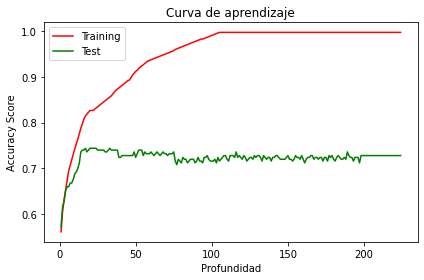

Profundidad óptima: 17
Árbol, porcentaje de aciertos en entrenamiento:  0.8146666666666667
Árbol, porcentaje de aciertos en test:  0.744


In [13]:
aux = decission_tree_optimum(train_vector_data, y_train, test_vector_data, y_test)
train_ac_list[1] = aux[0][0]
test_ac_list[1] = aux[0][1]

#### 1.2) 2-Grama

In [14]:
vectorizer, train_vector_data, test_vector_data = select_vectorizer(categoria = 'Binario', ngrama = (1,2),
                                                                    train_X = X_train, test_X = X_test)

##### 1.2.1) Naive Bayes Multinomial

In [15]:
aux = naive_bayes_multinomial(train_vector_data, y_train, test_vector_data, y_test)
train_ac_list[2] = aux[0][0]
test_ac_list[2] = aux[0][1]

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:  0.988
Multinomial Naive Bayes, porcentaje de aciertos en test:  0.756


##### 1.2.2) Árbol Decisión

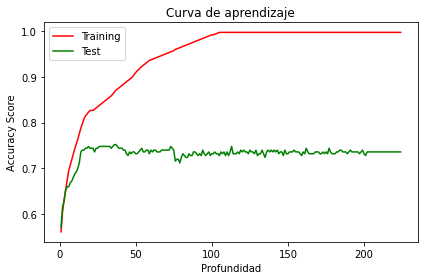

Profundidad óptima: 36
Árbol, porcentaje de aciertos en entrenamiento:  0.8666666666666667
Árbol, porcentaje de aciertos en test:  0.752


In [16]:
aux = decission_tree_optimum(train_vector_data, y_train, test_vector_data, y_test)
train_ac_list[3] = aux[0][0]
test_ac_list[3] = aux[0][1]

### 2) TF-IDF

#### 2.1) 1-Grama

In [17]:
vectorizer, train_vector_data, test_vector_data = select_vectorizer(categoria = 'TF-IDF', ngrama = (1,1),
                                                                    train_X = X_train, test_X = X_test)

##### 2.1.1) Naive Bayes Gaussiano

In [18]:
aux = naive_bayes_gaussian(train_vector_data, y_train, test_vector_data, y_test)
train_ac_list[4] = aux[0][0]
test_ac_list[4] = aux[0][1]

Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento:  0.932
Gaussian Naive Bayes, porcentaje de aciertos en test:  0.64


##### 2.1.2) Árbol de Decisión

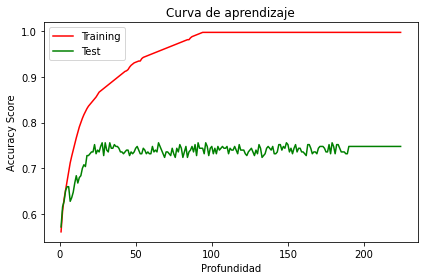

Profundidad óptima: 28
Árbol, porcentaje de aciertos en entrenamiento:  0.872
Árbol, porcentaje de aciertos en test:  0.756


In [19]:
aux = decission_tree_optimum(train_vector_data, y_train, test_vector_data, y_test)
train_ac_list[5] = aux[0][0]
test_ac_list[5] = aux[0][1]

#### 2.2) 2-Grama

In [20]:
vectorizer, train_vector_data, test_vector_data = select_vectorizer(categoria = 'TF-IDF', ngrama = (1,2),
                                                                    train_X = X_train, test_X = X_test)

##### 2.2.1) Naive Bayes Gaussiano

In [21]:
aux = naive_bayes_gaussian(train_vector_data, y_train, test_vector_data, y_test)
train_ac_list[6] = aux[0][0]
test_ac_list[6] = aux[0][1]

Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento:  0.9506666666666667
Gaussian Naive Bayes, porcentaje de aciertos en test:  0.644


##### 2.2.2) Arbol Decision

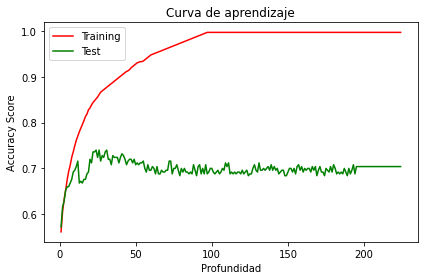

Profundidad óptima: 24
Árbol, porcentaje de aciertos en entrenamiento:  0.852
Árbol, porcentaje de aciertos en test:  0.74


In [22]:
aux = decission_tree_optimum(train_vector_data, y_train, test_vector_data, y_test)
train_ac_list[7] = aux[0][0]
test_ac_list[7] = aux[0][1]

### 3) Resultados

Una vez hemos ejecutado cada una de las configuraciones, visualizamos los resultados en una tabla. Coloreamos en verde y en rojo las 2 mejores y peores tasas de aciertos en test respectivamente.

In [23]:
# Creamos un data frame con los resultados obtenidos, estos están almacenados en la tabla creada al principio: ac_list
res_df = pd.DataFrame.from_dict({'Categoria' : ['Binario', 'Binario', 'Binario', 'Binario', 'TF-IDF', 'TF-IDF','TF-IDF','TF-IDF',],
                                 'N-Grama' : ['1-Grama', '1-Grama', '2-Grama', '2-Grama', '1-Grama', '1-Grama', '2-Grama', '2-Grama'],
                                 'Clasificador' : ['MultinomialNB', 'Arbol', 'MultinomialNB', 'Arbol', 'GaussianNB', 'Arbol', 
                                                'GaussianNB', 'Arbol',],
                                 'Train Accuracy' : train_ac_list, 'Test Accuracy' : test_ac_list})

# Creamos una pivot_table y le damos formato para ver los resultados de cada combinación y clasificador correctamente
colored_res_df = pd.pivot_table(res_df, index=['Categoria', 'N-Grama', 'Clasificador'])
colored_res_df = colored_res_df.style.apply(highlight_min_max)
colored_res_df

Observando la tabla, en un primer vistazo podemos extraer dos claras conclusiones. 

En primer lugar, vemos que **los dos peores resultados se obtienen con el clasificador Naive Bayes Gaussiano**. Este clasificador es el que peor desempeño muestra. **El mal funcionamiento de este tiene que ver con que la distribución de los valores que tienen los términos en el documento no siguen una distribución normal**. 


En segundo lugar, podemos afirmar que, exceptuando los resultados del Gaussiano, **las tasas de aciertos de los demás son muy similares entre si**, rondando todas ellas alrededor del 75%. Luego, **no podemos asegurar que haya un clasificador superior a los demás, pero sí que hay uno inferior, que es el Gaussiano**.

Por otro lado, como los resultados son en todas las configuraciones similares, vemos que añadir bigramas y TF-IDF **no nos está aportando un efecto positivo en ninguno de los clasificadores**, más allá de una cierta mejoría en los árboles que parece romperse al añadir bigramas y TF-IDF. El NB Multinomial parece empeorar y el Gaussiano mejora imperceptiblemente al añadir complejidad.

En resumen, estamos añadiendo complejidad a cambio de nada. Los bigramas funcionan bien cuando hay dos palabras seguidas que resultan ser muy discriminantes juntas. Por ejemplo: "Bill Gates" por separado parece indicar temas de cuentas o jardinería, pero junto es una palabra muy discriminante que apunta hacia la informática.

Sin embargo, el mejor árbol de decisión con bigramas solo contiene, entre sus 25 variables más discriminantes, una variable compuesta por dos palabras: "good way" (como podemos ver en la siguiente celda). Este dato explica que los bigramas no aporten mejoría: no aportan variables más discriminantes.

In [24]:
# De la tabla de resultados, seleccionamos el mejor árbol de decisión
best_tree = res_df[res_df['Clasificador'] == 'Arbol']
best_tree = best_tree[best_tree['N-Grama'] == '2-Grama']
best_tree = best_tree[best_tree['Test Accuracy'] == max(best_tree['Test Accuracy'])]
# print(best_tree)

# Seleccionamos el vectorizer y matrices de datos de dicho árbol
ngrama = (1,1) if best_tree.iloc[0]['N-Grama'] == '1-Grama' else (1,2)
bt_vectorizer, bt_train_vector_data, bt_test_vector_data = select_vectorizer(best_tree.iloc[0]['Categoria'], ngrama, X_train, X_test)

# Almacenamos el clasificador del mejor árbol para analizar a fondo sus resultados posteriormente
ac, bt_classifier = decission_tree_optimum(bt_train_vector_data, y_train, bt_test_vector_data, y_test, show = False)

# Almacenamos las predicciones en el conjunto de test del mejor árbol para analizar a fondo sus resultados posteriormente
bt_test_predictions = bt_classifier.predict(bt_test_vector_data)

# Imprimimos las 25 variables con más poder discriminante del mejor árbol de decisión con bigramas
print_top25_features_in_trees(bt_vectorizer, bt_classifier)

Top 25 features in the tree

great / good / amazing / delicious / fantastic / nice / perfect / awesome / happy / love / excellent / best / loved / friendly / vegas / wonderful / fun / good way / ice / service / bread / mouth / restaurants / average / like


A continuación, seleccionamos el mejor árbol de decisión e imprimimos las 25 variables con más poder discriminante.

In [25]:
# De la tabla de resultados, seleccionamos el mejor árbol de decisión
best_tree = res_df[res_df['Clasificador'] == 'Arbol']
best_tree = best_tree[best_tree['Test Accuracy'] == max(best_tree['Test Accuracy'])]
# print(best_tree)

# Seleccionamos el vectorizer y matrices de datos de dicho árbol
ngrama = (1,1) if best_tree.iloc[0]['N-Grama'] == '1-Grama' else (1,2)
bt_vectorizer, bt_train_vector_data, bt_test_vector_data = select_vectorizer(best_tree.iloc[0]['Categoria'], ngrama, X_train, X_test)

# Almacenamos el clasificador del mejor árbol para analizar a fondo sus resultados posteriormente
ac, bt_classifier = decission_tree_optimum(bt_train_vector_data, y_train, bt_test_vector_data, y_test, show = False)

# Almacenamos las predicciones en el conjunto de test del mejor árbol para analizar a fondo sus resultados posteriormente
bt_test_predictions = bt_classifier.predict(bt_test_vector_data)

# Imprimimos las 25 variables con más poder discriminante del mejor árbol de decisión
print_top25_features_in_trees(bt_vectorizer, bt_classifier)

Top 25 features in the tree

great / good / amazing / delicious / nice / fantastic / best / place / perfect / friendly / fresh / love / awesome / excellent / happy / order / definitely / way / vegas / restaurant / tender / fun / bread / loved / enjoyed


Claramente, predominan las palabras de sentimiento positivo, véase *great, good, amazing...* Las primeras palabras *great* y *good* tienen una frecuencia altísima en el diccionario, lo que puede contribuir a que aparezcan de primeras por estar más entrenadas. Nota: no hay más críticas positivas que negativas, hay 521 positivas versus 530 negativas.

Examinando el archivo *yelp_labelled.txt*, no parece que contenga ruido en el sentido de tener mal clasificadas algunas críticas. Sí que se puede observar un cierto sobreaprendizaje por palabras como *restaurant* o *place*, que no contienen un significado positivo o negativo por sí mismas (sentimiento neutro) y que pueden ser consideradas como ruido en el árbol pues no tiene sentido clasificar por ellas.

A continuación, seleccionamos el mejor Naive Bayes e imprimimos las 25 variables con más presencia en cada clase:

+ ¿Tienen sentido las palabras seleccionadas? ¿hay ruido (palabras sin sentimiento o de sentimiento opuesto al esperado)? ¿por qué crees que suceden estos fenómenos?

In [26]:
#De la tabla de resultados, seleccionamos el mejor Naive Bayes
best_NB = res_df[res_df['Clasificador'] != 'Arbol']
best_NB = best_NB[best_NB['Test Accuracy'] == max(best_NB['Test Accuracy'])]

#Seleccionamos el vectorizer y matrices de datos de dicho Naive Bayes
ngrama = (1,1) if best_NB.iloc[0]['N-Grama'] == '1-Grama' else (1,2)
bNB_vectorizer, bNB_train_vector_data, bNB_test_vector_data = select_vectorizer(best_NB.iloc[0]['Categoria'], ngrama, X_train, X_test)

#Almacenamos el clasificador del mejor Naive Bayes para analizar a fondo sus resultados
if(best_NB.iloc[0]['Clasificador'] == 'MultinomialNB') :
    ac, bNB_classifier = naive_bayes_multinomial(bNB_train_vector_data, y_train, bNB_test_vector_data, y_test, show = False)
else :
    ac, bNB_classifier = naive_bayes_gaussian(bNB_train_vector_data, y_train, bNB_test_vector_data, y_test, show = False)

#Almacenamos las predicciones en el conjunto de test del mejor Naive Bayes para analizar a fondo sus resultados
bNB_test_predictions = bNB_classifier.predict(bNB_test_vector_data)

In [27]:
#Imprimimos las 25 variables con mas presencia en cada clase del mejor Naive Bayes
print_top25_features_per_class_in_NB(bNB_vectorizer, bNB_classifier, ['Negative', 'Positive'])

Top 25 features per class

Negative: food / service / place / like / don / good / bad / just / got / time / did / think / ve / going / wasn / came / minutes / won / disappointed / worst / better / bland / way / really / restaurant 

Positive: good / great / food / place / service / nice / amazing / delicious / best / really / friendly / just / time / love / fantastic / staff / experience / menu / restaurant / awesome / fresh / vegas / like / excellent / perfect 



En la clase positiva, vemos como las palabras sí que representan en su mayoría sentimientos positivos. No obstante, en la clase negativa, nos encontramos con mucho ruido. Palabras que no expresan emociones negativas como *food, service o place* e incluso palabras que realmente expresan el sentimiento contrario como *good o like*.

Viendo el mejor NB y el mejor árbol, todo parece indicar a que es capaz de distinguir mejor las críticas positivas y que las críticas negativas las consigue por descarte y sobreaprendiendo. ¿Por qué? Puede ser, por ejemplo, debido a que las críticas positivas tienden a adular al resturante con adjetivos que usa para distinguir y las críticas negativas tienden a explicar la situación por la que no les gustó. Esto genera que el árbol crea que la mejor manera de clasificar es mediante los positivos y que el NB tenga en la clase negativa un montón de ruido fruto de sobreaprender.

#### Conclusiones

Podemos concluir que el clasificador gaussiano es, en este caso, el más inadecuado. Quizás, si el tamaño del corpus fuese mayor, la distribución de los valores de los términos se asemejarían más a la distribución normal, pudiéndonos aportar mejores resultados.

Añadir complejidad mediante TF-IDF o bigramas no parece haber sido de gran ayuda en este caso, añaden complejidad y los resultados no fueron mejores en los clasificadores.

Si tuviéramos que elegir entre el Árbol de Decisión o el Naive Bayes Multinomial, en primera instancia decidiría el Naive Bayes. Pero no por una cuestión de mejores resultados, pues estos hemos visto que son similares, sino porque para el árbol hemos de encontrar la profundidad óptima, lo que nos resulta muy costoso en tiempo. Para tamaños de corpus mayores, encontrar la profundidad óptima quizás sea inabordable.

### Apartado b)

De nuevo, definimos antes que nada una serie de funciones auxiliares que vamos a usar durante este segundo apartado. Comentamos aquí brevemente cada una de dichas funciones. En caso de que se quieran conocer más a fondo, recomendamos consultar el código, pues este está documentado y comentado.

Las funciones que vamos a usar en este segundo apartado son:

+ **plot_confusion_matrix**: dados un vector de valores predichos y valores reales, imprime la matriz de confusión.
    
+ **get_wrong_predictions**: dados un vector de valores predichos y un conjunto de datos reales, devuelve dos listas con todas las críticas que han sido falsas positivas y falsas negativas.
    
+ **write_terms**:  Escribe la frase original y los términos presentes en un mensaje representado como bolsa de palabras.

In [28]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    
    """
    Dados un vector de valores predichos y valores reales, imprime la matriz de confusión.
    Imprime y dibuja la matriz de confusión.
    Se puede aplicar normalización mediante normalize=True .
    
    Parámetros:
    - y_true -- Valores reales
    - y_pred -- Valores predichos
    - classes -- Nombre de las clases a predecir
    - title -- Título para la matriz
    - cmap -- Color para la matriz
    
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Calcula la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    # Solo usa las clases que aparezcan en los datos
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Girar las etiquetas y sus alineaciones
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Crear anotaciones sobre las dimensiones de los datos
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    return ax


In [29]:
def get_wrong_predictions(test, predictions) :
    """
    Devuelve dos listas con todas las críticas que han sido falsas positivas
    y falsas negativas.
    
    Parámetros:
    - test -- Conjunto de test
    - predictions -- Vector de predicciones
    
    """
    
    falsas_positivas = []
    falsas_negativas = []
    i = 0
    
    # Para cada fila del conjunto de test, vemos si es falsa positiva o falsa negativa, en cuyo caso la almacenamos
    for index, row in test.iterrows():
        
        # Falsas Positivas
        if(test.loc[index][1] == 0 and predictions[i] == 1) : 
            falsas_positivas.append((i, row[0], row[1]))
        
        # Falsas Negativas    
        if(test.loc[index][1] == 1 and predictions[i] == 0) :
            falsas_negativas.append((i, row[0], row[1]))
        
        i = i + 1
    
    # Devolvemos ambas listas
    return falsas_positivas, falsas_negativas

In [34]:
import numpy as np
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, i):
    '''
    Escribe la frase original y los términos presentes en un mensaje representado como bolsa de palabras.
    
    Parametros:
    - feature_names: términos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    
    '''
    # Máscara para seleccionar solo el mensaje en posición index
    index = data[i][0]
    mask = vector_data[index,:]>0
    
    # Términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # Mostrar mensaje original
    if data:
        print('Mensaje', index, ':', data[i][1])
    
    # Mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

Procedemos ahora a analizar a fondo los resultados del mejor clasificador Naive Bayes y el mejor árbol de decisión anteriormente escogidos.

Comenzando por el mejor Naive Bayes, imprimimos su matriz de confusión y sus métricas de clasificación.

Confusion matrix, without normalization
[[94 31]
 [28 97]]

Métricas de Clasificación

              precision    recall  f1-score   support

    Negative       0.77      0.75      0.76       125
    Positive       0.76      0.78      0.77       125

    accuracy                           0.76       250
   macro avg       0.76      0.76      0.76       250
weighted avg       0.76      0.76      0.76       250



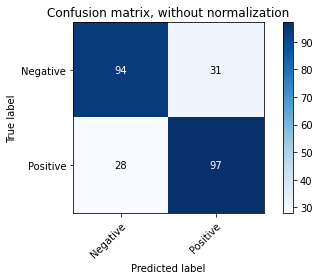

In [35]:
# Imprimimos la matriz de confusion del mejor Naive Bayes
plot_confusion_matrix(y_test, bNB_test_predictions, normalize=False, classes=np.array(['Negative', 'Positive']))

# Imprimimos las métricas de clasificación para el mejor Naive Bayes
print("\nMétricas de Clasificación\n")
bt_cr = classification_report(y_test,bNB_test_predictions, target_names=np.array(['Negative', 'Positive']))
print(bt_cr)

Pasamos ahora a analizar el mejor Árbol de Decisión. Imprimimos pues, su matriz de confusión y sus métricas de clasificación.

Confusion matrix, without normalization
[[105  20]
 [ 41  84]]

 Métricas de Clasificación

              precision    recall  f1-score   support

    Negative       0.72      0.84      0.77       125
    Positive       0.81      0.67      0.73       125

    accuracy                           0.76       250
   macro avg       0.76      0.76      0.75       250
weighted avg       0.76      0.76      0.75       250



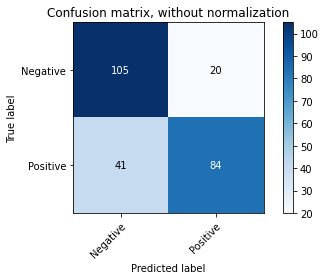

In [36]:
# Imprimimos la matriz de confusión del mejor Árbol de Decisión
plot_confusion_matrix(y_test, bt_test_predictions, normalize=False, classes=np.array(['Negative', 'Positive']))

# Imprimimos las metricas de clasificación para el mejor Árbol de Decisión
print("\n Métricas de Clasificación\n")
bt_cr = classification_report(y_test,bt_test_predictions, target_names=np.array(['Negative', 'Positive']))
print(bt_cr)

**1. Analiza la precisión y la exhaustividad de cada clasificador en cada una de las clases (opiniones positivas y negativas).**

    + Para cada clasificador, ¿tiene un comportamiento homogéneo a la hora de clasificar ambas clases?

    + ¿Cuáles son las fortalezas y debilidades de cada uno de los clasificadores?

    + ¿Hay algún clasificador que sea mejor que el otro en todo?

    + ¿Coinciden ambos clasificadores a la hora de clasificar mejor una clase que la otra?
    

El mejor clasificador NB tiene una precisión y una exaustividad muy similares,
ya que tiene prácticamente el mismo número de falsos negativos que de falsos positivos. Tanto la precisión como la exhaustividad superan el 75%, lo que sin duda hace que sea un gran clasificador. Como son tan similares, clasifica de forma homogénea críticas positivas y negativas.

El mejor árbol de decisión, por el contrario, tiende a clasificar como negativas las críticas (tiene muchos falsos negativos). Esto provoca que tenga más aciertos negativos y menos aciertos positivos que el clasificador NB. Esto se refleja en la exhaustividad: nos dice que el árbol identifica correctamente al 84% de los negativos y al 68% de los positivos, lo que quiere decir que más negativos y menos positivos acaban identificados correctamente comparándolo con el clasificador NB. Esto repercute también en que los que escoge como positivos es más seguro que lo sean (precisión 81% vs 76%) y los que escoge como negativos es más probable que haya fallado (precisión 72% vs 77%) en comparación con el clasificador NB.

En resumen, el clasificador NB es homogéneo y el árbol tiende a clasificar como negativo, motivos por los que el árbol clasifica peor en su totalidad los positivos. Esto tiene la ventaja de que si clasifica como positivo, es más probable que lo sea (es estricto con declarar una crítica como positiva y eso hace que se reduzcan los falsos positivios).

El NB clasifica mejor los positivos y el árbol clasifica mejor los negativos (globalmente). No es uno mejor que otro, depende para qué se quieran: el NB podría usarse como test inicial para distinguir con una fiabilidad del 75% si es positivo o negativo y el árbol sería útil para verificar que un positivo lo es, por ejemplo.

**2. Pinta los 8 primeros niveles del árbol de decisión y comenta lo que ves.**

    + ¿Qué estructura tiene el árbol?

    + ¿Cómo interpretas los niveles que has pintado? ¿tienen algún sentido con respecto a la tasa de aciertos, o la precisión y exhaustividad del clasificador?

    + ¿Hay nodos impuros?

Siguiendo con el análisis del mejor Árbol de Decisión, vamos a pintar sus primero 8 niveles con la esperanza de entender cómo ha actuado el clasificador.

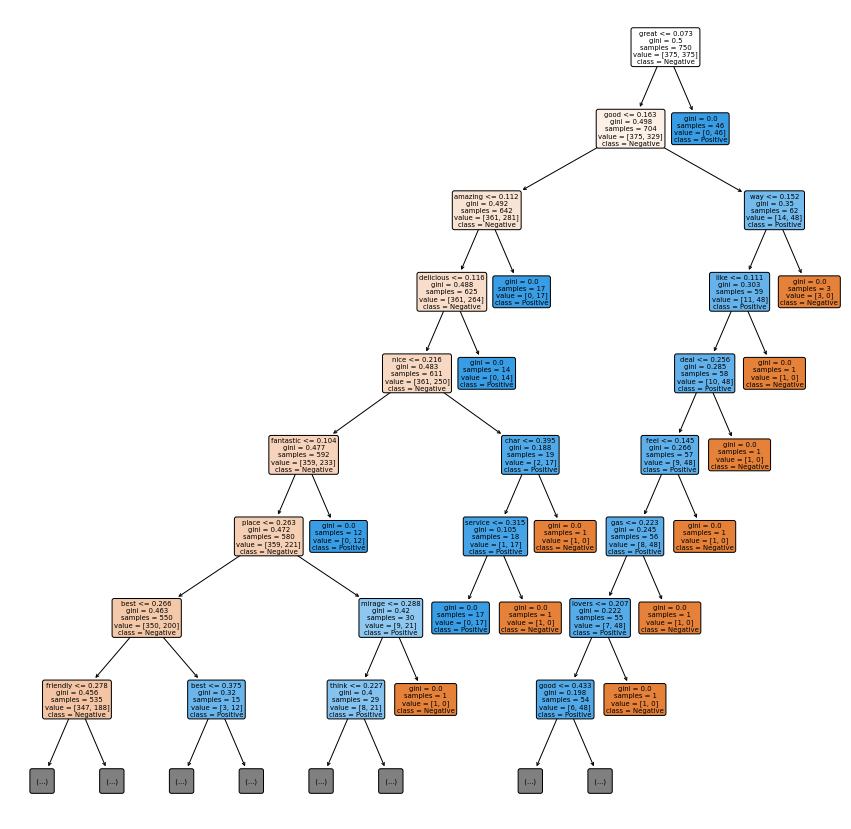

In [37]:
# Mostramos los primeros 8 niveles del mejor Arbol de Decision
plt.figure(figsize=(15,15))
plot_tree(bt_classifier, max_depth = 8, feature_names = bt_vectorizer.get_feature_names(), class_names = ['Negative', 'Positive'], filled=True, rounded=True)
plt.show()

El árbol es un árbol binario bastante alargado, donde la mayoría de nodos tienen un nodo hijo que es un nodo hoja del árbol, por lo que no está equilibrado.

Observemos todos los nodos hoja visibles en el diagrama. Podemos ver que la mayoría clasifican como Negativo, pero hacen referencia a solamente un elemento. La mayoría de elementos clasificados definitivamente antes del último nivel es de tipo Positivo, lo cual tiene sentido porque el árbol tenía mayor precisión en los de tipo Positivo.

Si observamos el último nivel dibujado, veremos que el nodo que se expande a los siguientes niveles y que clasifica como Negativo contiene a la mayoría de elementos aún (vemos aquí que de momento tiende a tener falsos negativos, y eso provocará una alta exhaustividad en los de tipo Negativo). Además contiene, al igual que toda su rama, una alta impureza de Gini, lo que nos indica que casi la mitad de los elementos de ese nodo son de un tipo distinto. Nótese que la impureza de Gini no puede ser mayor que 0.5, pues solamente hay dos clases y, de superarse, la clasificación del nodo cambia, quedando la impureza como 1-impureza_anterior. Esa rama contiene por tanto a los nodos más impuros.

Los otros tres nodos que se expanden a niveles no pintados clasifican como Positivo y tienen una impureza mucho menor, por lo que se refuerza el dato de que tendrá mayor precisión en los de tipo Positivo.

**3. Por cada clasificador identifica 2 críticas que hayan sido falsas positivas (malas críticas calificadas como buenas) y 2 críticas que han sido falsas negativas (buenas críticas clasificadas como malas).**

In [40]:
#Obtenemos las criticas que han sido falsas positivas y falsas negativas del mejor Arbol de Decision
bt_falsas_positivas, bt_falsas_negativas = get_wrong_predictions(X_test, bt_test_predictions)

#De entre las falsas positivas, escogemos 2 y escribimos tanto su texto original como el vector de palabras resultantes
#En este caso hemos escogido la primera y la segunda de la lista
print("Falsas Positivas")
write_terms(bt_vectorizer.get_feature_names(), bt_falsas_positivas, bt_test_vector_data, 0)
write_terms(bt_vectorizer.get_feature_names(), bt_falsas_positivas, bt_test_vector_data, 1)

#De entre las falsas negativas, escogemos 2 y escribimos tanto su texto original como el vector de palabras resultantes
#En este caso hemos escogido la primera y la segunda de la lista
print("Falsas Negativas")
write_terms(bt_vectorizer.get_feature_names(), bt_falsas_negativas, bt_test_vector_data, 0)
write_terms(bt_vectorizer.get_feature_names(), bt_falsas_negativas, bt_test_vector_data, 1)

Falsas Positivas
Mensaje 0 : The scallop dish is quite appalling for value as well.
Mensaje 0 vectorizado: ['dish' 'quite' 'value'] 

Mensaje 50 : We started with the tuna sashimi which was brownish in color and obviously wasn't fresh.
Mensaje 50 vectorizado: ['color' 'fresh' 'sashimi' 'started' 'tuna' 'wasn'] 

Falsas Negativas
Mensaje 2 : An extensive menu provides lots of options for breakfast.
Mensaje 2 vectorizado: ['breakfast' 'menu' 'options'] 

Mensaje 13 : There was a warm feeling with the service and I felt like their guest for a special treat.
Mensaje 13 vectorizado: ['feeling' 'felt' 'like' 'service' 'special' 'treat' 'warm'] 



In [41]:
#Obtenemos las criticas que han sido falsas positivas y falsas negativas del mejor Naive Bayes
bNB_falsas_positivas, bNB_falsas_negativas = get_wrong_predictions(X_test, bNB_test_predictions)

#De entre las falsas positivas, escogemos 2 y escribimos tanto su texto original como el vector de palabras resultantes
#En este caso hemos escogido la primera y la segunda
print("Falsas Positivas")
write_terms(bNB_vectorizer.get_feature_names(), bNB_falsas_positivas, bNB_test_vector_data, 6)
write_terms(bNB_vectorizer.get_feature_names(), bNB_falsas_positivas, bNB_test_vector_data, 7)

#De entre las falsas negativas, escogemos 2 y escribimos tanto su texto original como el vector de palabras resultantes
#En este caso hemos escogido la primera y la segunda
print("Falsas Negativas")
write_terms(bNB_vectorizer.get_feature_names(), bNB_falsas_negativas, bNB_test_vector_data, 6)
write_terms(bNB_vectorizer.get_feature_names(), bNB_falsas_negativas, bNB_test_vector_data, 7)

Falsas Positivas
Mensaje 55 : !....THE OWNERS REALLY REALLY need to quit being soooooo cheap let them wrap my freaking sandwich in two papers not one!
Mensaje 55 vectorizado: ['cheap' 'let' 'need' 'owners' 'really' 'sandwich' 'wrap'] 

Mensaje 57 : Soggy and not good.
Mensaje 57 vectorizado: ['good' 'soggy'] 

Falsas Negativas
Mensaje 48 : The food came out at a good pace.
Mensaje 48 vectorizado: ['came' 'food' 'good' 'pace'] 

Mensaje 52 : Today was my first taste of a Buldogis Gourmet Hot Dog and I have to tell you it was more than I ever thought possible.
Mensaje 52 vectorizado: ['dog' 'hot' 'possible' 'taste' 'tell' 'thought' 'today'] 



**3. Analiza tanto su texto original, como el vector de palabras resultante (solamente los términos activos).**

    + ¿Por qué crees que ha fallado el clasificador en cada uno de los casos?

    + ¿Se te ocurre alguna idea sobre cómo mejorar el clasificador de sentimiento?

En el árbol:

Ninguna de las mal clasificadas que hemos seleccionado contiene alguna de las 25 características más discriminantes, por lo que el árbol contaba con poca información para clasificarlas.

De las falsas positivas, en la primera falta en la vectorización la palabra "appalling", que sería la determinante para averiguar que es negativa. Sin ella, se entiende que se clasifique como positiva.
En la segunda, haría falta tener bigramas para clasificarla bien: "too sweet" o "lacked flavor" ayudarían a clasificarla negativa. Tal como está, las palabras "really" o "sweet" discriminan más que "lacked" y acaba siendo positiva.

De las falsas negativas, la primera no contiene en el vector la palabra "extensive", lo que deja la clasificación de la frase a expensas de la frecuencia de palabras neutras como "breakfast" en otras críticas, y de ahí el problema.
La segunda contiene en el vector todas las palabras importantes, salvo quizás "guest". "special" y "warm" podrían haber sido determinantes para considerarla positiva pero parece que seguramente "like" haya conseguido clasificarla antes como negativa.

En el NB:

De las falsas positivas, en la primera, palabras como "freaking" ayudarían a clasificarla como negativa, pero si no estuviese en la frase sería muy difícil
clasificarla por estar contando lo que tienen que hacer y no criticando. La clasifica como positiva por contener la palabra "really".
En la segunda, con un bigrama cogería "not good" y probablemente la clasificaría bien. Tal como está, la clasifica como buena por "good", ignorando "soggy".

De las falsas negativas, la primera contiene todas las palabras importantes en el vector, pero el sobreaprendizaje hace que "food" sea de las más importantes
para clasificar como negativa (es ruido porque tiene sentimiento neutro), por lo que la clasifica mal.
En la segunda, coge la mayoría de las palabras importantes pero ninguna es útil para discriminar, por lo que o "hot" tiene alguna importancia discriminatoria que no vemos en el top 25, o distinguirá por la frecuencia de alguna de esas palabras con significado neutro en las críticas negativas, tirando de sobreaprendizaje.

**Mejoras:**

Parece que una buena técnica sería unir los diccionarios: el que generaría con todos estos textos y el que le pasamos del inglés. Esto permitiría reconocer todos los términos que no aparecían en el vector por no estar en el diccionario y que resultan determinantes: palabras malsonantes, tecnicismos etc.